In [2]:
# %%
# ---------------- [第一步：修正此单元格] ----------------
# 明确导入所有需要的库
%matplotlib inline
import numpy as np
from numpy import matrix
import matplotlib.pyplot as plt
import h5py
import inspect
import os
import pandas as pd

# 加载 autoreload 扩展
%load_ext autoreload
%autoreload 2

# 添加项目库路径
import path_utils
path_utils.add_path_to_sys_path("../../../code/python/lib", mode="relative_to_cwd", frame=inspect.currentframe())
import embree_utils

In [3]:
# 推荐的写法：明确导入库
%matplotlib inline
import numpy as np
from numpy import matrix  # 或者直接导入 matrix 函数
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib inline

In [5]:
import h5py
import inspect
import os
import pandas as pd

In [6]:
metadata_camera_parameters_csv_file = os.path.join("..", "metadata_camera_parameters.csv")

#
# we use ai_037_002 as our test scene because it has an especially unusual
# projection matrix and makes use of the the following non-standard lens
# parameters in V-Ray:
# 
# horizontal_offset = 0.06
# horizontal_shift  = 0.0
# lens_shift        = -0.009
# vertical_offset   = -0.08
#

# scene_name  = "ai_037_002"
# camera_name = "cam_00"
# frame_id    = 0

# # project all "sofa" vertices into our image
si = 1

# camera_dir = os.path.join(scene_name, "_detail", camera_name)
# img_dir    = os.path.join(scene_name, "images")

# # we need access to the Hypersim meshes in order to execute parts of this notebook
# mesh_dir = "/Volumes/lacie/hypersim/evermotion_dataset/scenes/" + scene_name + "/_detail/mesh"
# 设定我们要分析的场景和图像
scene_name  = "ai_001_001"
camera_name = "cam_00"
frame_id    = 0

# --- [核心修改] ---
# 构建场景数据的根目录的正确路径。
# Notebook 在 '.../jupyter/' 目录下，所以我们需要向上回退三级目录
# (.../mikeroberts3000/ -> .../contrib/ -> ml-hypersim/)
# 然后再进入 'examples/01_marketplace_dataset/scenes/'
base_scene_dir = os.path.abspath(os.path.join("..", "..", "..", "examples", "01_marketplace_dataset", "scenes", scene_name))

# 使用新的 base_scene_dir 来构建所有数据路径
camera_dir = os.path.join(base_scene_dir, "_detail", camera_name)
img_dir    = os.path.join(base_scene_dir, "images")
mesh_dir   = os.path.join(base_scene_dir, "_detail", "mesh")

# 打印路径以供检查，确保它们是正确的
print("Base Scene Directory:", base_scene_dir)
print("Camera Directory:", camera_dir)
print("Image Directory:", img_dir)
print("Mesh Directory:", mesh_dir)

Base Scene Directory: /root/workspace/ml-hypersim/examples/01_marketplace_dataset/scenes/ai_001_001
Camera Directory: /root/workspace/ml-hypersim/examples/01_marketplace_dataset/scenes/ai_001_001/_detail/cam_00
Image Directory: /root/workspace/ml-hypersim/examples/01_marketplace_dataset/scenes/ai_001_001/images
Mesh Directory: /root/workspace/ml-hypersim/examples/01_marketplace_dataset/scenes/ai_001_001/_detail/mesh


In [7]:
#
# read parameters from csv file
#

df_camera_parameters = pd.read_csv(metadata_camera_parameters_csv_file, index_col="scene_name")

df_ = df_camera_parameters.loc[scene_name]

width_pixels  = int(df_["settings_output_img_width"])
height_pixels = int(df_["settings_output_img_height"])

M_proj = matrix([[ df_["M_proj_00"], df_["M_proj_01"], df_["M_proj_02"], df_["M_proj_03"] ],
                 [ df_["M_proj_10"], df_["M_proj_11"], df_["M_proj_12"], df_["M_proj_13"] ],
                 [ df_["M_proj_20"], df_["M_proj_21"], df_["M_proj_22"], df_["M_proj_23"] ],
                 [ df_["M_proj_30"], df_["M_proj_31"], df_["M_proj_32"], df_["M_proj_33"] ]])

In [8]:
#
# retrieve all vertices belonging to a particular semantic ID
#

mesh_vertices_hdf5_file   = os.path.join(mesh_dir, "mesh_vertices.hdf5")
mesh_faces_vi_hdf5_file   = os.path.join(mesh_dir, "mesh_faces_vi.hdf5")
mesh_faces_oi_hdf5_file   = os.path.join(mesh_dir, "mesh_faces_oi.hdf5")
mesh_objects_si_hdf5_file = os.path.join(mesh_dir, "mesh_objects_si.hdf5")

with h5py.File(mesh_vertices_hdf5_file,   "r") as f: mesh_vertices   = f["dataset"][:]
with h5py.File(mesh_faces_vi_hdf5_file,   "r") as f: mesh_faces_vi   = f["dataset"][:]
with h5py.File(mesh_faces_oi_hdf5_file,   "r") as f: mesh_faces_oi   = f["dataset"][:]
with h5py.File(mesh_objects_si_hdf5_file, "r") as f: mesh_objects_si = f["dataset"][:]

# 修正后的代码
fi_si = np.where(np.in1d(mesh_faces_oi, np.where(mesh_objects_si == si)[0]))[0]
assert fi_si.shape[0] > 0

mesh_faces_vi_si = mesh_faces_vi[fi_si]
mesh_vertices_si_ = mesh_vertices[mesh_faces_vi_si.ravel()]

mesh_positions_world = mesh_vertices_si_

(768.0, 0.0)

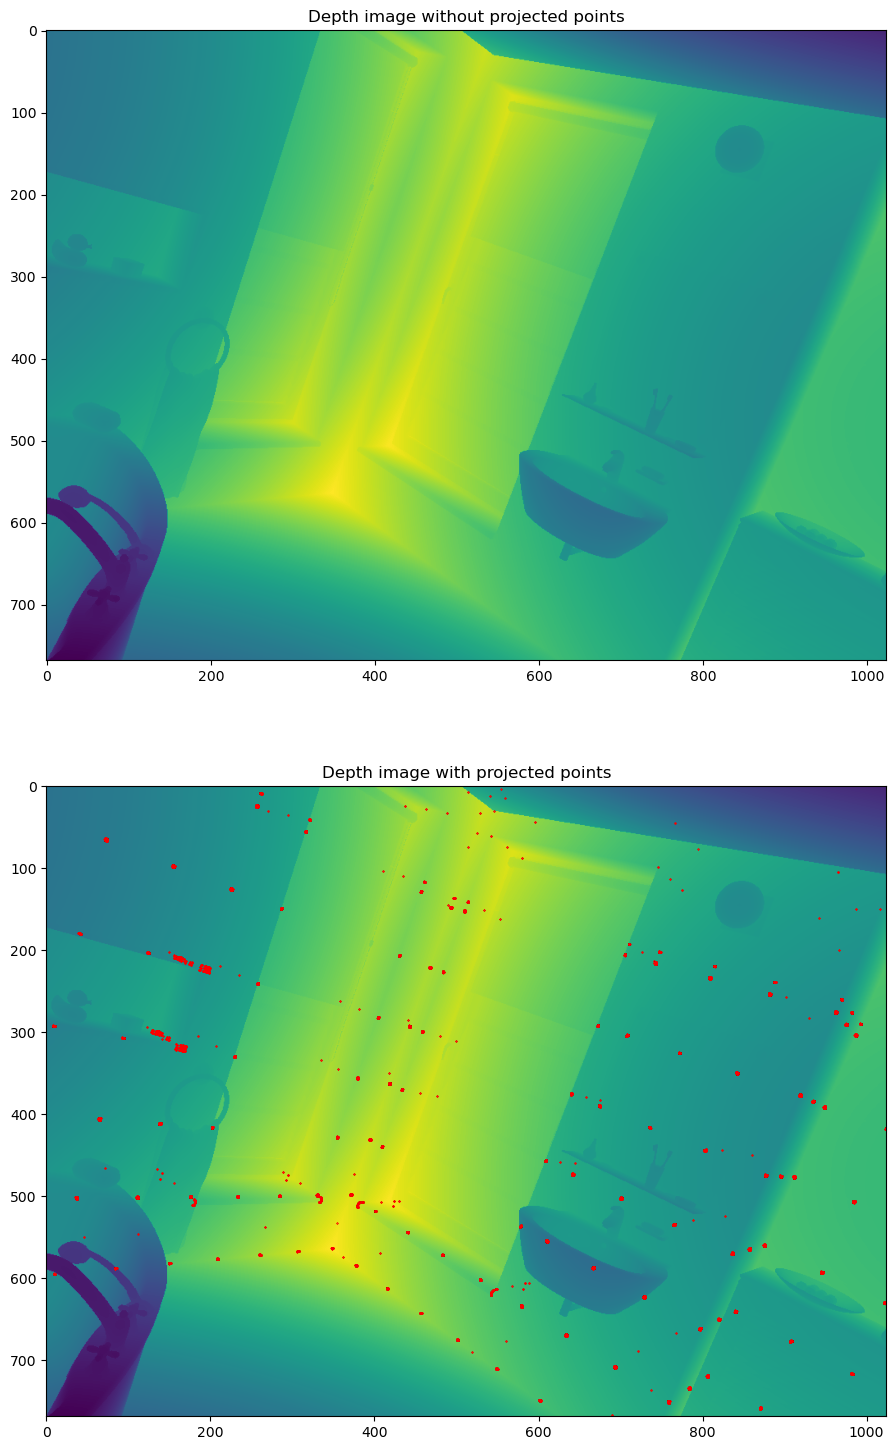

In [9]:
# %%
# ---------------- [第三步：完整修正此单元格] ----------------
#
# verify that we are projecting points to their correct screen-space positions
#

camera_positions_hdf5_file    = os.path.join(camera_dir, "camera_keyframe_positions.hdf5")
camera_orientations_hdf5_file = os.path.join(camera_dir, "camera_keyframe_orientations.hdf5")

depth_meters_hdf5_file = os.path.join(img_dir, "scene_" + camera_name + "_geometry_hdf5", "frame.%04d.depth_meters.hdf5" % frame_id)

with h5py.File(camera_positions_hdf5_file,    "r") as f: camera_positions    = f["dataset"][:]
with h5py.File(camera_orientations_hdf5_file, "r") as f: camera_orientations = f["dataset"][:]

with h5py.File(depth_meters_hdf5_file, "r") as f: depth_meters = f["dataset"][:].astype(np.float32)

# matrix to map to integer screen coordinates from normalized device coordinates
M_screen_from_ndc = np.matrix([[0.5*(width_pixels-1), 0,                      0,   0.5*(width_pixels-1)],
                            [0,                    -0.5*(height_pixels-1), 0,   0.5*(height_pixels-1)],
                            [0,                    0,                      0.5, 0.5],
                            [0,                    0,                      0,   1.0]])

# get position and rotation matrix for Hypersim image
camera_position_world = camera_positions[frame_id]
R_world_from_cam      = camera_orientations[frame_id]

t_world_from_cam = np.matrix(camera_position_world).T
R_cam_from_world = np.matrix(R_world_from_cam).T
t_cam_from_world = -R_cam_from_world*t_world_from_cam

M_cam_from_world = np.matrix(np.block([[R_cam_from_world, t_cam_from_world],
                                 [np.matrix(np.zeros(3)), 1.0]]))

num_points = mesh_positions_world.shape[0]

P_world  = np.matrix( np.c_[ mesh_positions_world, np.ones(num_points) ] ).T
P_cam    = M_cam_from_world*P_world
P_clip   = M_proj*P_cam
P_ndc    = np.matrix(P_clip.A/P_clip.A[3])
P_screen = M_screen_from_ndc*P_ndc

plt.figure(figsize=(18,18))

plt.subplot(211)
plt.imshow(depth_meters)
plt.title("Depth image without projected points")

plt.subplot(212)
plt.imshow(depth_meters)
plt.title("Depth image with projected points")
plt.scatter(P_screen[0].A1, P_screen[1].A1, color="red", s=0.05)
plt.axis('image') # 确保x和y轴的比例一致
plt.xlim(0, width_pixels) # 设置x轴的显示范围
plt.ylim(height_pixels, 0) # 设置y轴的显示范围（y轴向下为正）